<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [IMDB1] - Text embedding with IMDB
<!-- DESC --> A very classical example of word embedding for text classification (sentiment analysis)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Understand the management of **textual data** and **sentiment analysis**

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import os,sys,h5py,json
from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

place, datasets_dir = ooo.init()


FIDLE 2020 - Practical Work Module
Version              : 0.57 DEV
Run time             : Thursday 10 September 2020, 16:34:04
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Current place        : Fidle at IDRIS
Dataset dir          : /gpfswork/rech/mlh/commun/datasets
Update keras cache   : Done


## Step 2 - Retrieve data

**From Keras :**
This IMDb dataset can bet get directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

Due to their nature, textual data can be somewhat complex.

### 2.1 - Data structure :  
The dataset is composed of 2 parts: **reviews** and **opinions** (positive/negative),  with a **dictionary**

  - dataset = (reviews, opinions)
    - reviews = \[ review_0, review_1, ...\]
      - review_i = [ int1, int2, ...] where int_i is the index of the word in the dictionary.
    - opinions = \[ int0, int1, ...\] where int_j == 0 if opinion is negative or 1 if opinion is positive.
  - dictionary = \[ mot1:int1, mot2:int2, ... ]

### 2.2 - Get dataset
For simplicity, we will use a pre-formatted dataset.  
See : https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data  

However, Keras offers some usefull tools for formatting textual data.  
See : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text

In [2]:
vocab_size = 10000

# ----- Retrieve x,y
#
# Choose if you want to load dataset directly from keras (small size <20M)
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size,
                                                       skip_top   = 0,
                                                       maxlen     = None,
                                                       seed       = 42,
                                                       start_char = 1,
                                                       oov_char   = 2,
                                                       index_from = 3, )
# Or you can use the same pre-loaded dataset
#
# with  h5py.File(f'{datasets_dir}/IMDB/origine/dataset_imdb.h5','r') as f:
#        x_train = f['x_train'][:]
#        y_train = f['y_train'][:]
#        x_test  = f['x_test'][:]
#        y_test  = f['y_test'][:]

In [3]:
print("  Max(x_train,x_test)  : ", ooo.rmax([x_train,x_test]) )
print("  x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("  x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

print('\nReview example (x_train[12]) :\n\n',x_train[12])

  Max(x_train,x_test)  :  9999
  x_train : (25000,)  y_train : (25000,)
  x_test  : (25000,)  y_test  : (25000,)

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


### 2.3 - Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

In [4]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

In [5]:
print('\nDictionary size     : ', len(word_index))
for k in range(440,455):print(f'{k:2d} : {index_word[k]}' )
print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nIn real words :\n\n', dataset2text(x_train[12]))


Dictionary size     :  88587
440 : hope
441 : entertaining
442 : she's
443 : mr
444 : overall
445 : evil
446 : called
447 : loved
448 : based
449 : oh
450 : several
451 : fans
452 : mother
453 : drama
454 : beginning

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]

In real words :

 <start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong

### 2.4 - Have a look for NN

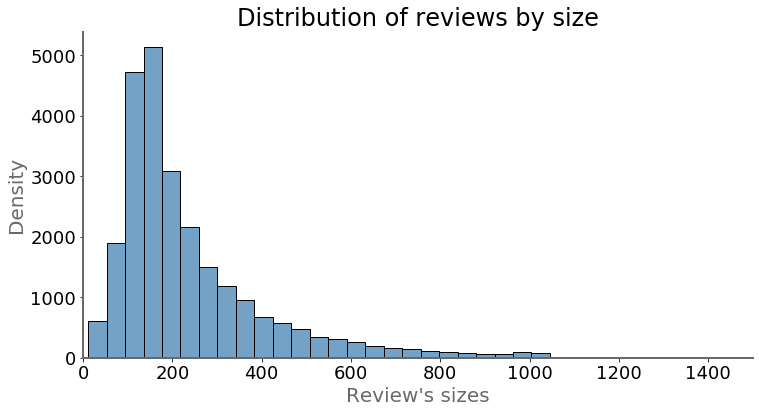

In [6]:
plt.figure(figsize=(12, 6))
ax=sns.histplot([len(i) for i in x_train],bins=60)
ax.set_title('Distribution of reviews by size')
plt.xlabel("Review's sizes")
plt.ylabel('Density')
ax.set_xlim(0, 1500)
plt.show()

## Step 3 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the same length.  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [7]:
review_len = 256

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nIn real words :\n\n', dataset2text(x_train[12]))


Review example (x_train[12]) :

 [   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   

### Save dataset and dictionary (For future use but not mandatory if at GRICAD or IDRIS)

In [8]:
# ---- To write h5 dataset in a test place (optional)
#      For small tests only !
#
output_dir = './data'
ooo.mkdir(output_dir)


with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model
Few remarks :
1. We'll choose a dense vector size for the embedding output with **dense_vector_size**
2. **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
In other words: we average the set of vectors/words of a sentence
3. L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer

A SUIVRE : https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks
### 4.1 - Build
More documentation about :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [9]:
def get_model(dense_vector_size=32):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(dense_vector_size, activation='relu'))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [10]:
model = get_model(32)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [11]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it

In [12]:
%%time

n_epochs   = 30
batch_size = 512

history = model.fit(x_train,
                    y_train,
                    epochs          = n_epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Epoch 1/30
49/49 [==============================] - 1s 23ms/step - loss: 0.6884 - accuracy: 0.6085 - val_loss: 0.6783 - val_accuracy: 0.6292
Epoch 2/30
49/49 [==============================] - 1s 16ms/step - loss: 0.6497 - accuracy: 0.7349 - val_loss: 0.6142 - val_accuracy: 0.7631
Epoch 3/30
49/49 [==============================] - 1s 16ms/step - loss: 0.5548 - accuracy: 0.8092 - val_loss: 0.5105 - val_accuracy: 0.8291
Epoch 4/30
49/49 [==============================] - 1s 16ms/step - loss: 0.4420 - accuracy: 0.8572 - val_loss: 0.4182 - val_accuracy: 0.8461
Epoch 5/30
49/49 [==============================] - 1s 17ms/step - loss: 0.3576 - accuracy: 0.8790 - val_loss: 0.3624 - val_accuracy: 0.8609
Epoch 6/30
49/49 [==============================] - 1s 17ms/step - loss: 0.3047 - accuracy: 0.8928 - val_loss: 0.3303 - val_accuracy: 0.8690
Epoch 7/30
49/49 [==============================] - 1s 17ms/step - loss: 0.2689 - accuracy: 0.9030 - val_loss: 0.3116 - val_accuracy: 0.8744
Epoch 8/30
49

## Step 6 - Evaluate
### 6.1 - Training history

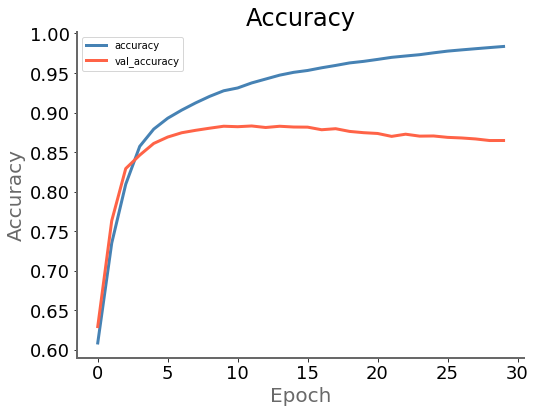

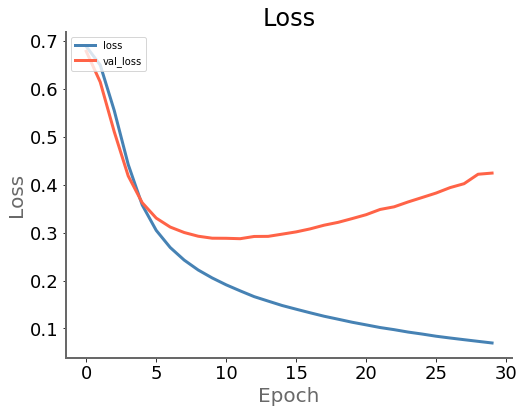

In [13]:
ooo.plot_history(history)

### 6.2 - Reload and evaluate best model

x_test / loss      : 0.2873
x_test / accuracy  : 0.8830


#### Accuracy donut is :

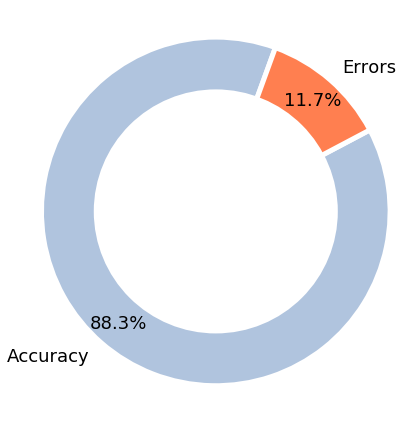

#### Confusion matrix is :

,0,1
0,1.00,0.00
1,1.00,0.00


In [15]:
model = keras.models.load_model('./run/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
ooo.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :")

# ---- Confusion matrix

#y_pred   = model.predict_classes(x_test)           Deprecated after 01/01/2021 !!

y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

# ooo.display_confusion_matrix(y_test,y_pred,labels=range(2),color='orange',font_size='20pt')
ooo.display_confusion_matrix(y_test,y_pred,labels=range(2))


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>